# Bibliotecas utilizadas:

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from collections import namedtuple

# from tensorflow.python.framework import ops

from keras.models import Sequential
from keras.layers import LSTM, Dense

from tensorflow import keras

# Import:

In [4]:
train_data = pd.read_csv(r"train.csv")
test_data = pd.read_csv(r"test.csv")

# Funções:

In [5]:
def missingdata(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    ms=pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    ms= ms[ms["Percent"] > 0]
    f,ax =plt.subplots(figsize=(12,9))
    plt.xticks(rotation=90)
    fig=sns.barplot(ms.index, ms["Percent"],color="green",alpha=0.8)
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of missing values', fontsize=15)
    plt.title('Percent missing data by feature', fontsize=15)
    return ms

In [6]:
def split_valid_test_data(data, fraction=(1 - 0.8)):
    data_y = data["Survived"]
    lb = LabelBinarizer()
    data_y = lb.fit_transform(data_y)

    data_x = data.drop(["Survived"], axis=1)

    train_x, valid_x, train_y, valid_y = train_test_split(data_x, data_y, test_size=fraction)

    return train_x.values, train_y, valid_x, valid_y

In [7]:
# Define function to create input/output sequences for LSTM - Long Short-Term Memory
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data)-sequence_length-1):
        X.append(data[i:(i+sequence_length), :])
        y.append(data[(i+sequence_length), 0])
    return np.array(X), np.array(y)

# Feature Engineer:

C:\Users\GAMER\AppData\Roaming\Python\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


,Total,Percent
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467


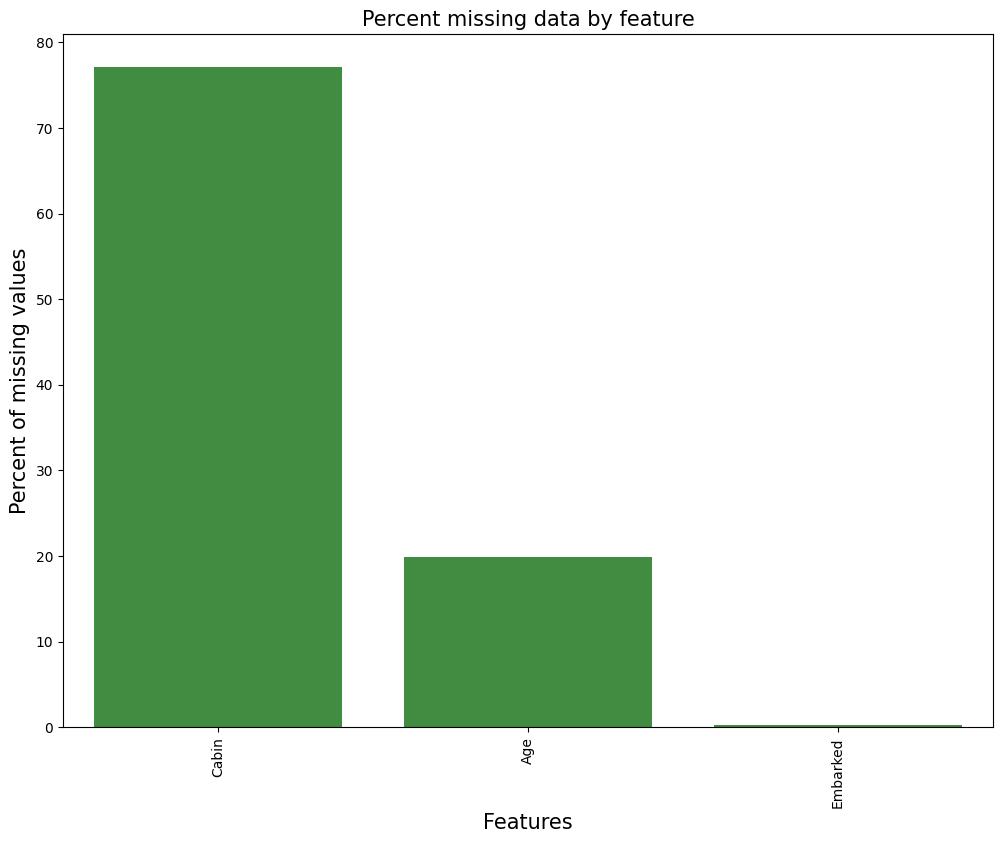

In [8]:
missingdata(train_data)

In [9]:
train_age = train_data.dropna(subset=['Age'])
train_age = train_age.reset_index(drop=True)

In [10]:
test_age = test_data.dropna(subset=['Age'])
test_age = test_age.reset_index(drop=True)

In [11]:
test_data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [12]:
test_age

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
327,1301,3,"Peacock, Miss. Treasteall",female,3.0,1,1,SOTON/O.Q. 3101315,13.7750,NaN,S
328,1303,1,"Minahan, Mrs. William Edward (Lillian E Thorpe)",female,37.0,1,0,19928,90.0000,C78,Q
329,1304,3,"Henriksson, Miss. Jenny Lovisa",female,28.0,0,0,347086,7.7750,NaN,S
330,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C


In [13]:
def nan_padding(data, columns):
    for column in columns:
        imputer=KNNImputer()
        data[column]=imputer.fit_transform(data[column].values.reshape(-1,1))
    return data

nan_columns = ["Age"]

train_data = nan_padding(train_data, nan_columns)
test_data = nan_padding(test_data, nan_columns)

In [14]:
#save PassengerId for evaluation
test_passenger_id=test_data["PassengerId"]

In [15]:
def drop_not_concerned(data, columns):
    return data.drop(columns, axis=1)

not_concerned_columns = ["PassengerId","Name", "Ticket", "Fare", "Cabin", "Embarked"]
train_data = drop_not_concerned(train_data, not_concerned_columns)
test_data = drop_not_concerned(test_data, not_concerned_columns)

In [16]:
train_age = drop_not_concerned(train_age, not_concerned_columns)
test_age = drop_not_concerned(test_age, not_concerned_columns)

In [17]:
def dummy_data(data, columns):
    for column in columns:
        data = pd.concat([data, pd.get_dummies(data[column], prefix=column)], axis=1)
        data = data.drop(column, axis=1)
    return data

dummy_columns = ["Pclass"]
train_data = dummy_data(train_data, dummy_columns)
test_data = dummy_data(test_data, dummy_columns)

In [18]:
train_age = dummy_data(train_age, dummy_columns)
test_age = dummy_data(test_age, dummy_columns)

In [19]:
def sex_to_int(data):
    le = LabelEncoder()
    le.fit(["male","female"])
    data["Sex"]=le.transform(data["Sex"]) 
    return data

train_data = sex_to_int(train_data)
test_data = sex_to_int(test_data)

In [20]:
train_age = sex_to_int(train_age)
test_age = sex_to_int(test_age)

In [21]:
def normalize_age(data):
    scaler = MinMaxScaler()
    data["Age"] = scaler.fit_transform(data["Age"].values.reshape(-1,1))
    return data

train_data = normalize_age(train_data)
test_data = normalize_age(test_data)

In [22]:
def normalize_sibsp(data):
    scaler = MinMaxScaler()
    data["SibSp"] = scaler.fit_transform(data["SibSp"].values.reshape(-1,1))
    return data

train_data = normalize_sibsp(train_data)
test_data = normalize_sibsp(test_data)

In [23]:
train_age = normalize_sibsp(train_age)
test_age = normalize_sibsp(test_age)

In [24]:
def normalize_parch(data):
    scaler = MinMaxScaler()
    data["Parch"] = scaler.fit_transform(data["Parch"].values.reshape(-1,1))
    return data

train_data = normalize_parch(train_data)
test_data = normalize_parch(test_data)

In [25]:
train_age = normalize_parch(train_age)
test_age = normalize_parch(test_age)

In [26]:
train_data.describe()

,Survived,Sex,Age,SibSp,Parch,Pclass_1,Pclass_2,Pclass_3
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,0.647587,0.367921,0.065376,0.063599,0.242424,0.206510,0.551066
std,0.486592,0.477990,0.163383,0.137843,0.134343,0.428790,0.405028,0.497665
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.271174,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.367921,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,1.000000,0.434531,0.125000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
test_data.describe()

,Sex,Age,SibSp,Parch,Pclass_1,Pclass_2,Pclass_3
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,0.636364,0.396975,0.055921,0.043594,0.255981,0.222488,0.521531
std,0.481622,0.166617,0.112095,0.109048,0.436934,0.416416,0.500135
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.301068,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.396975,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,0.469207,0.125000,0.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [28]:
X = train_data.drop(['Survived'], axis=1)
y = train_data['Survived']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

# Modelagem:

In [30]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score

activation: Um monte, teste -> bom estudar
sigmoid: limita entre zero e um
loss estudar também
optimizer fórmula do gradiente descendente (como ele vai treinar) Menos suscetivel a minimos locais
metrics não faz nada, só pra mostrar
epochs -> Época
Plotar treino e validação
Outras arquiteturas
batch_size -> Divide em lote
Previsão de idade (Excluir o Survived) -> Regressão

In [31]:
model = Sequential()
model.add(Dense(units=32, activation='relu', input_dim=len(X_train.columns)))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

In [32]:
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics='accuracy')

In [33]:
# Mostra o progresso do treinamento imprimindo um único ponto para cada epoch completada
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 200

history = model.fit(
  X, y,
  epochs=EPOCHS, validation_split = 0.2, verbose=0, batch_size=32,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................

In [34]:
hist = pd.DataFrame(history.history)
hist

,loss,accuracy,val_loss,val_accuracy
0,0.671847,0.625000,0.662881,0.653631
1,0.661797,0.627809,0.651188,0.653631
2,0.653264,0.629214,0.641057,0.642458
3,0.645865,0.623595,0.632126,0.642458
4,0.639181,0.609551,0.624192,0.642458
...,...,...,...,...
195,0.439744,0.806180,0.394120,0.832402
196,0.439641,0.807584,0.393597,0.832402
197,0.439821,0.806180,0.393222,0.832402
198,0.439771,0.806180,0.392956,0.832402


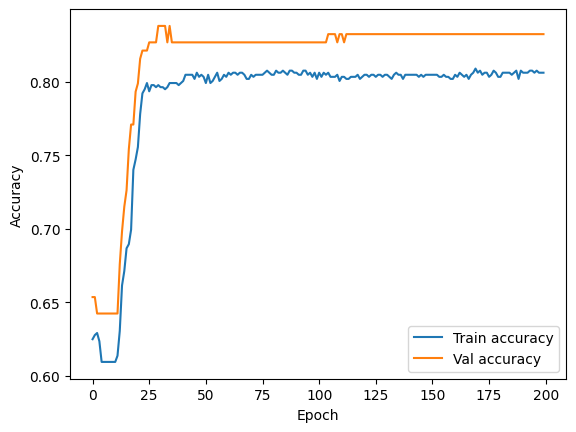

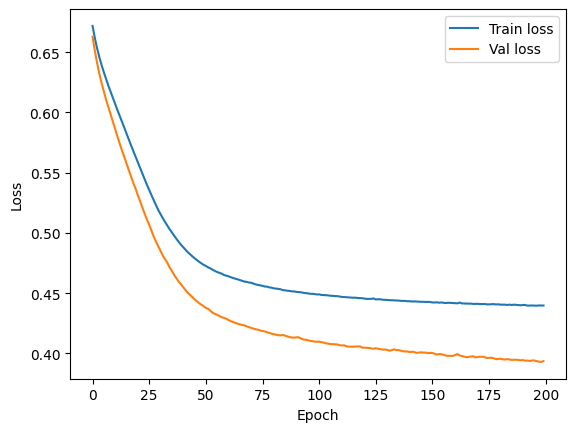

In [35]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],
             label='Train accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Val accuracy')
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],
             label='Train loss')
    plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val loss')
    plt.legend()

plot_history(history)

w = model.fit(X_train, y_train, epochs=200, batch_size=32)

y_hat = model.predict(X_test)
y_hat = [0 if val < 0.5 else 1 for val in y_hat]

accuracy_score(y_test, y_hat)

# Brincadeira 2:

In [30]:
train_data = pd.read_csv(r"train.csv")

In [31]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [35]:
X = pd.get_dummies(train_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1))
y = train_data['Survived']

In [39]:
X.isna().value_counts()

Survived  Pclass  Age    SibSp  Parch  Fare   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S
False     False   False  False  False  False  False       False     False       False       False         891
dtype: int64

In [38]:
def nan_padding(data, columns):
    for column in columns:
        imputer=KNNImputer()
        data[column]=imputer.fit_transform(data[column].values.reshape(-1,1))
    return data

nan_columns = ["Age"]

X = nan_padding(X, nan_columns)

In [46]:
X.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [41]:
model = Sequential()
model.add(Dense(units=32, activation='relu', input_dim=len(X_train.columns)))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

In [42]:
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics='accuracy')

In [44]:
y_hat = model.predict(X_test)
y_hat = [0 if val < 0.5 else 1 for val in y_hat]

6/6 [==============================] - 0s 2ms/step


In [45]:
accuracy_score(y_test, y_hat)

0.9888268156424581

# Idade:

In [36]:
train_age = train_age.drop(columns='Survived')

In [37]:
X_train_2 = train_age.drop(columns='Age')
y_train_2 = train_age['Age']

In [38]:
X_train_2.head()

,Sex,SibSp,Parch,Pclass_1,Pclass_2,Pclass_3
0,1,0.2,0.0,0,0,1
1,0,0.2,0.0,1,0,0
2,0,0.0,0.0,0,0,1
3,0,0.2,0.0,1,0,0
4,1,0.0,0.0,0,0,1


In [39]:
y_train_2.head()

0    22.0
1    38.0
2    26.0
3    35.0
4    35.0
Name: Age, dtype: float64

In [40]:
X_test_2 = test_age.drop(columns='Age')
y_test_2 = test_age['Age']

In [41]:
X_test_2.head()

,Sex,SibSp,Parch,Pclass_1,Pclass_2,Pclass_3
0,1,0.000,0.000000,0,0,1
1,0,0.125,0.000000,0,0,1
2,1,0.000,0.000000,0,1,0
3,1,0.000,0.000000,0,0,1
4,0,0.125,0.166667,0,0,1


In [42]:
y_test_2.head()

0    34.5
1    47.0
2    62.0
3    27.0
4    22.0
Name: Age, dtype: float64

In [43]:
model = Sequential()
model.add(Dense(units=32, activation='relu', input_dim=len(X_train_2.columns)))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(1)) # Default é relu

In [44]:
optimizer = tf.keras.optimizers.RMSprop(0.001)

In [45]:
model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mape', 'mse'])

In [46]:
model.fit(X_train_2, y_train_2, epochs=200, batch_size=32)

Epoch 1/200
23/23 [==============================] - 0s 1ms/step - loss: 1073.2906 - mae: 29.3436 - mape: 97.2164 - mse: 1073.2906
Epoch 2/200
23/23 [==============================] - 0s 1ms/step - loss: 1006.3938 - mae: 28.1862 - mape: 92.5088 - mse: 1006.3938
Epoch 3/200
23/23 [==============================] - 0s 1ms/step - loss: 916.5335 - mae: 26.6545 - mape: 90.8515 - mse: 916.5335
Epoch 4/200
23/23 [==============================] - 0s 1ms/step - loss: 800.5591 - mae: 24.5920 - mape: 91.1898 - mse: 800.5591
Epoch 5/200
23/23 [==============================] - 0s 1ms/step - loss: 662.5464 - mae: 22.0162 - mape: 95.7706 - mse: 662.5464
Epoch 6/200
23/23 [==============================] - 0s 1ms/step - loss: 517.2552 - mae: 18.9507 - mape: 102.6681 - mse: 517.2552
Epoch 7/200
23/23 [==============================] - 0s 1ms/step - loss: 382.3916 - mae: 15.5604 - mape: 110.3311 - mse: 382.3916
Epoch 8/200
23/23 [==============================] - 0s 1ms/step - loss: 283.3967 - mae: 12

In [47]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                224       
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,401
Trainable params: 2,401
Non-trainable params: 0
_________________________________________________________________


In [48]:
example_batch = X_train_2[:10]
example_result = model.predict(example_batch)
example_result

1/1 [==============================] - 0s 91ms/step


array([[25.237997],
       [36.23672 ],
       [23.194262],
       [36.23672 ],
       [28.326796],
       [42.770275],
       [10.079183],
       [24.55924 ],
       [29.40732 ],
       [18.001528]], dtype=float32)

11/11 [==============================] - 0s 1ms/step


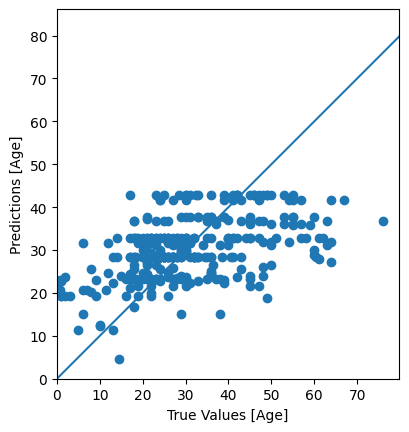

In [49]:
test_predictions = model.predict(X_test_2).flatten()
test_labels = y_test_2

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Age]')
plt.ylabel('Predictions [Age]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

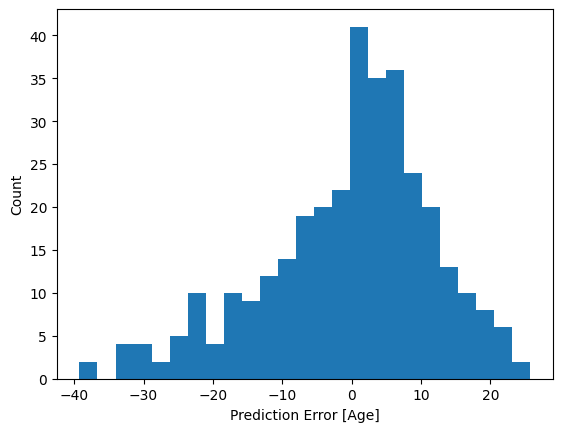

In [50]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Age]")
_ = plt.ylabel("Count")

In [51]:
# Mostra o progresso do treinamento imprimindo um único ponto para cada epoch completada
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 1000

history = model.fit(
  X_train_2, y_train_2,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [54]:
hist = pd.DataFrame(history.history)
hist

,loss,mae,mape,mse,val_loss,val_mae,val_mape,val_mse
0,144.695663,9.364182,82.679192,144.695663,159.324005,9.937910,160.862701,159.324005
1,144.356552,9.436605,83.538452,144.356552,158.065918,9.840605,157.160019,158.065918
2,144.209351,9.432508,82.910866,144.209351,159.357391,9.895081,158.947311,159.357391
3,144.197952,9.421810,82.876427,144.197952,161.417770,9.983711,161.704376,161.417770
4,144.493729,9.439059,82.125587,144.493729,163.097260,10.064329,164.633469,163.097260
...,...,...,...,...,...,...,...,...
995,131.210648,8.945922,69.279701,131.210648,162.286575,9.827967,163.280655,162.286575
996,131.861984,8.944239,69.606689,131.861984,163.835938,9.930408,166.923782,163.835938
997,131.799866,8.944818,69.736115,131.799866,166.852768,10.082714,172.182724,166.852768
998,131.615829,8.929125,68.594681,131.615829,166.964752,10.092484,172.358368,166.964752


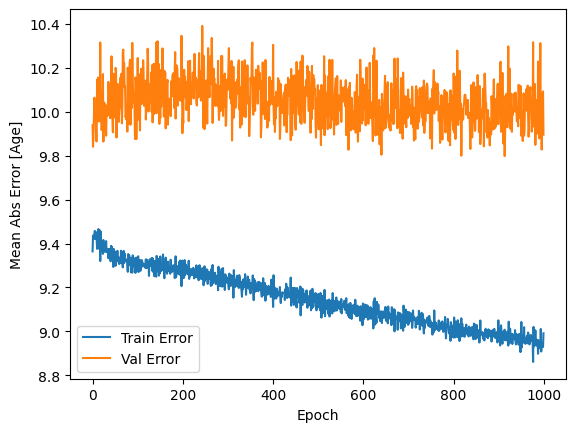

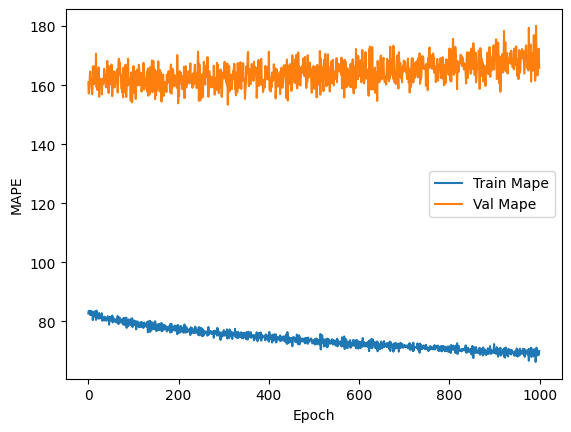

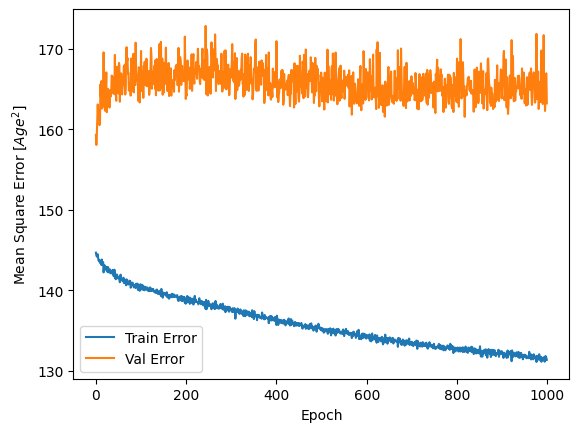

In [52]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [Age]')
    plt.plot(hist['epoch'], hist['mae'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('MAPE')
    plt.plot(hist['epoch'], hist['mape'],
           label='Train Mape')
    plt.plot(hist['epoch'], hist['val_mape'],
           label = 'Val Mape')
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$Age^2$]')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
    plt.legend()
    plt.show()

plot_history(history)